<a href="https://colab.research.google.com/github/jollygoodjacob/NASA-Space-Apps-Workshop-2024/blob/main/PyTorch_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

If you haven't already, make sure to install the required packages in your environment.

In [ ]:
%pip install earthaccess geopandas rasterio shapely

In [ ]:
%pip install torch torchvision torchaudio numpy polars matplotlib hvplot pillow bokeh holoviews

We will start by importing **default packages**. These are part of Python itself, so they will always be available.

In [ ]:
import time
import os

Now, let's add some third-party packages that will find useful for a variety of tasks:

In [ ]:
# Multi-dimensional arrays ("tensors") for Python
import numpy as np

# A library that lets us work with data in a tabular format
import pandas as pd
import polars as pl

# Plotting library (lets us create graphs of things)
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# Another plotting library
import hvplot
import holoviews as hv
import hvplot.polars
import hvplot.pandas

# PyTorch, a deep learning library that is also useful for differentiable programming and performing
# operations on tensors using the GPU or other accelerators
import torch
from torch import nn
import torchvision

In [ ]:
# Set up hvplot
hv.extension('bokeh')
os.environ['HV_DOC_HTML'] = 'true'

We can also print information about our GPU or TPU, if we have one available. Otherwise, we'll stick to using our CPU.

In [ ]:
print(f"CUDA Available: {torch.cuda.is_available()}")

# Create a variable to store our device (we will use this to move our data to the correct device)
DEVICE = None

# Set the device to the first available GPU or TPU. If on MacOS with M1, use MPS. Otherwise use the CPU.
if torch.cuda.is_available():
    print(f"CUDA Device Count: {torch.cuda.device_count()}")
    DEVICE = torch.device("cuda")
    print(f"Using device: {torch.cuda.get_device_name()}")

elif 'TPU_NAME' in os.environ:
    import torch_xla.core.xla_model as xm
    DEVICE = xm.xla_device()
    print(f"Using TPU: {os.environ['TPU_NAME']}")

elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    DEVICE = torch.device("mps")
    print("Using device: MPS")

else:
    DEVICE = torch.device("cpu")
    print("Using device: CPU")

CUDA Available: False
Using device: MPS


# Tensors

Let's try messing around with some tensors to get the hang of them. We will start by creating a 2D tensor with a height of 3 and width of 4. We want the initial values of the tensor to be random, so we use `torch.rand`.

In [ ]:
rand_tensor = torch.rand(3, 4, device=DEVICE)

display(rand_tensor)

tensor([[0.9701, 0.6845, 0.3909, 0.4248],
        [0.0541, 0.5769, 0.4354, 0.1415],
        [0.7116, 0.0091, 0.0793, 0.7044]], device='mps:0')

We can also create a tensor of zeros using `torch.zeros`:

In [ ]:
zeros_tensor = torch.zeros(3, 4, device=DEVICE)

display(zeros_tensor)

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], device='mps:0')

We can modify the data in a tensor using a Python-standard syntax:

In [ ]:
zeros_tensor[1][1] = 1

display(zeros_tensor)

tensor([[0., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 0.]], device='mps:0')

One can do mathematical operations on tensors with scalars as well:

In [ ]:
zeros_tensor += 1

display(zeros_tensor)

tensor([[1., 1., 1., 1.],
        [1., 2., 1., 1.],
        [1., 1., 1., 1.]], device='mps:0')

Because our tensors have the same dimension, we can easily do simple mathematical operations *with multiple* the tensors! These kind of operations are performed **element-wise**.

This means that element `rand_tensor[0][0]` is added to `zeros_tensor[0][0]`, and `rand_tensor[1][1]` is added to `zeros_tensor[1][1]`, and so on.

In [ ]:
combined_tensor = rand_tensor + zeros_tensor

display(combined_tensor)

tensor([[1.9701, 1.6845, 1.3909, 1.4248],
        [1.0541, 2.5769, 1.4354, 1.1415],
        [1.7116, 1.0091, 1.0793, 1.7044]], device='mps:0')

Linear algebra functions are also supported.

$$\begin{bmatrix}1 \\ 3 \end{bmatrix} \cdot \begin{bmatrix}5 & 6 & 4\end{bmatrix}$$

In [ ]:
A = torch.tensor(
    [[1],
     [3]], dtype=torch.float32, device=DEVICE)

B = torch.tensor(
    [[5, 6, 4]], dtype=torch.float32, device=DEVICE)

AB = torch.matmul(A, B)

display(AB)

tensor([[ 5.,  6.,  4.],
        [15., 18., 12.]], device='mps:0')

Doing operations on large tensors can be **much** faster on the GPU than it is on the CPU. Just be careful, because moving data to the GPU has its own cost!

In [ ]:
def test_cpu_tensors(size):
    """Element-wise add two 2D tensors of `size` on CPU"""
    cpu_x = torch.rand(size, size, device="cpu")
    cpu_y = torch.rand(size, size, device="cpu")

    return cpu_x + cpu_y


def test_gpu_tensors(size):
    """Element-wise add two 2D tensors of `size` on GPU"""
    gpu_x = torch.rand(size, size, device=DEVICE)
    gpu_y = torch.rand(size, size, device=DEVICE)

    return gpu_x + gpu_y


# Time CPU vs. GPU on a 10,000x10,000 2D tensor
time_init = time.time()
test_cpu_tensors(10000)
time_cpu = time.time()
test_gpu_tensors(10000)
time_gpu = time.time()

print(f"CPU Time: {time_cpu - time_init}s")
print(f"GPU Time: {time_gpu - time_cpu}s")

CPU Time: 0.7256031036376953s
GPU Time: 0.0074007511138916016s


Sometimes, it is helpful to visualize tensors. We can do this using Numpy, Polars, and HvPlot.

In [ ]:
pl.DataFrame(combined_tensor.to("cpu").numpy()).hvplot.heatmap()

:HeatMap   [columns,index]   (value)

# Using PyTorch for Data Analysis

If our dataset, or even just parts of it can fit in our GPU's memory, we can use PyTorch to do our analysis very fast!

Let's start by re-importing those helpful packages from before.

In [ ]:
# Import Required Packages
import os
import earthaccess
import geopandas as gpd
import rasterio as rio
import rasterio.merge
import shapely

# Also pillow, a library for working with images
from PIL import Image

/Users/adam/Dropbox/Research/Competitions/NASA-Space-Apps-2024/NASA-Space-Apps-Workshop-2024/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's download a Mars imagery dataset:

In [ ]:
!curl -o "/tmp/hirise-map-proj-v3.zip" -LO "https://zenodo.org/records/2538136/files/hirise-map-proj-v3.zip?download=1"
!mkdir -p "/tmp/hirise-map-proj-v3"
!unzip "/tmp/hirise-map-proj-v3.zip" -d "/tmp/hirise-map-proj-v3"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  940M  100  940M    0     0  6261k      0  0:02:33  0:02:33 --:--:-- 3603k 940M    0  324k    0     0   226k      0  1:10:47  0:00:01  1:10:46  226k940M   33  311M    0     0  8314k      0  0:01:55  0:00:38  0:01:17 7762k 940M   40  376M    0     0  8316k      0  0:01:55  0:00:46  0:01:09 8444k 0:01:12  0:00:42 6123k  940M   68  644M    0     0  7468k      0  0:02:08  0:01:28  0:00:40 3325k 940M   71  670M    0     0  7341k      0  0:02:11  0:01:33  0:00:38 5120k  7302k      0  0:02:11  0:01:35  0:00:36 5288k  940M   82  778M    0     0  6787k      0  0:02:21  0:01:57  0:00:24 4456k  940M   85  807M    0     0  6642k      0  0:02:24  0:02:04  0:00:20 4200k0M   97  921M    0     0  6354k      0  0:02:31  0:02:28  0:00:03 3982k
Archive:  hirise-map-proj-v3.zip
  inflating: landmarks_map-proj-v3_classmap.csv  
  inflating: labels

We can load one of the images as a tensor:

tensor([[131., 130., 129.,  ..., 163., 157., 154.],
        [128., 128., 128.,  ..., 165., 159., 156.],
        [126., 127., 127.,  ..., 168., 162., 158.],
        ...,
        [131., 137., 145.,  ..., 119., 118., 119.],
        [131., 135., 142.,  ..., 111., 108., 109.],
        [132., 134., 139.,  ..., 108., 104., 103.]], device='mps:0')

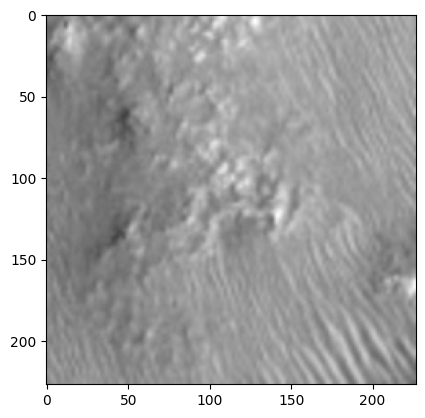

In [ ]:
image = Image.open("/tmp/hirise-map-proj-v3/map-proj-v3/ESP_020606_1445_RED-0640-r180.jpg")
image_tensor = torch.tensor(np.array(image), dtype=torch.float32, device=DEVICE)

# Display as text
display(image_tensor)

# Display as image
display(plt.imshow(image_tensor.to("cpu"), vmin=0, vmax=255, cmap="gray"))

Let's try to brighten the image a bit using some basic math.

tensor([[170.3000, 169.0000, 167.7000,  ..., 211.9000, 204.1000, 200.2000],
        [166.4000, 166.4000, 166.4000,  ..., 214.5000, 206.7000, 202.8000],
        [163.8000, 165.1000, 165.1000,  ..., 218.4000, 210.6000, 205.4000],
        ...,
        [170.3000, 178.1000, 188.5000,  ..., 154.7000, 153.4000, 154.7000],
        [170.3000, 175.5000, 184.6000,  ..., 144.3000, 140.4000, 141.7000],
        [171.6000, 174.2000, 180.7000,  ..., 140.4000, 135.2000, 133.9000]],
       device='mps:0')

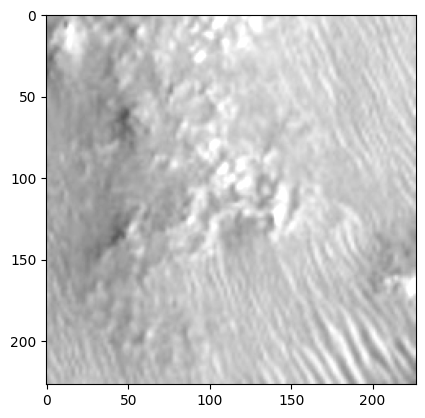

In [ ]:
dark_image = image_tensor * 1.3

# Display as text
display(dark_image)

# Display as image
display(plt.imshow(dark_image.to("cpu"), vmin=0, vmax=255, cmap="gray"))

# Neural Network Basics

PyTorch is a deep learning framework designed for machine learning applications. So, let's try building a super basic neural network.

In [ ]:
class TinyMLP(torch.nn.Module):
    def __init__(self):
        """Create a simple multi-layer perceptron, which we label `TinyMLP`."""
        super(TinyMLP, self).__init__()

        self.linear1 = torch.nn.Linear(8, 20)   # Linear layer (input dimensions, output dimensions)
        self.activation = torch.nn.ReLU()       # Activation function
        self.linear2 = torch.nn.Linear(20, 3)
        self.softmax = torch.nn.Softmax(dim=0)  # Normalize to prob. dist.

    def forward(self, x):
        """
        Define what the forward pass does for `TinyMLP`.

        Essentially, chain together the functions that make up each
        layer/activation function.

        @param x: Input tensor
        @return: Result after passing through all layers/activation functions
        """
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x

Let's try it out with some dummy data. We can see that the data is processed by the MLP using the forward pass code we wrote in `TinyMLP.forward()`.

The overall concept of this simple MLP is:
```
input • weights1 |> activation (ReLU) |> input • weights2 |> softmax |> output
```

In [ ]:
my_tinymlp = TinyMLP().to(DEVICE)  # Create the model and move it to the device

x = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0])
x = x.to(DEVICE)

y_est = my_tinymlp(x)
display(y_est)

tensor([0.1172, 0.4764, 0.4065], device='mps:0', grad_fn=<SoftmaxBackward0>)

## Backpropagation

PyTorch lets us use calculus to figure out *how* to improve our model **automatically**! This is what makes deep neural networks so powerful.

Visualization of differentiating with a limit:
<iframe src="https://www.desmos.com/calculator/8oobrhwhai?embed" width="500" height="500" style="border: 1px solid #ccc" frameborder=0></iframe>

It's very important to remember that backpropagation does not necessarily mean that we *do* any updates! "Backprop" just tells us which direction we need to move and by about how much.

Let's drop back down to the super basic level and build our own simple neural network using only tensors, activation functions, and some kind of way to **measure how bad our model is**. We call this measurement the **"loss"**.

In [ ]:
# Create tensors
input = torch.rand(4, requires_grad=True, device=DEVICE)
target = torch.tensor([0.5], device=DEVICE)
weights = torch.rand(4, requires_grad=True, device=DEVICE)
print(f"Weights: {weights}")

# Create functions
act_fn = torch.nn.SiLU()    # or ReLU, etc.
loss_fn = torch.nn.L1Loss() # or CrossEntropyLoss, etc.

# Run example operation (dot product)
output = act_fn(torch.dot(input, weights))
print(f"Actual Result: {output}\nDesired: {target[0]}")

# Calculate loss
loss = loss_fn(output, target)
print(f"Loss: {loss}")

# Automatically compute gradients using compute graph
loss.backward()

# Print gradients for the loss with respect to the weights
print(f"Weight Grad: {weights.grad}")

# Note: Backpropagation doesn't necessarily imply updates!

Weights: tensor([0.8620, 0.6464, 0.0757, 0.4138], device='mps:0', requires_grad=True)
Actual Result: 0.37546494603157043
Desired: 0.5
Loss: 0.12453505396842957
Weight Grad: tensor([-0.0702, -0.4670, -0.1655, -0.1911], device='mps:0')


/Users/adam/Dropbox/Research/Competitions/NASA-Space-Apps-2024/NASA-Space-Apps-Workshop-2024/.venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
